In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

from IPython.core.display import HTML
HTML("<style>.container{ width: 90% !important; }</style>")

# read in & view our data set

In [ ]:
import pandas as pd
df = pd.read_parquet('titanic.parquet')
df.head()

In [13]:
# do a meta review 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PassengerId      891 non-null    int64         
 1   Survived         891 non-null    int64         
 2   Pclass           891 non-null    int64         
 3   Name             891 non-null    object        
 4   Sex              891 non-null    object        
 5   Age              714 non-null    float64       
 6   SibSp            891 non-null    int64         
 7   Parch            891 non-null    int64         
 8   Ticket           891 non-null    object        
 9   Fare             891 non-null    float64       
 10  Cabin            204 non-null    object        
 11  Embarked         889 non-null    object        
 12  event_timestamp  891 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory usage: 90.6+ KB


we could explore more with [Pandas Profiling](https://github.com/ydataai/ydata-profiling) 
[e.g.](https://ydata-profiling.ydata.ai/examples/master/meteorites/meteorites_report.html)

In [14]:
# also useful
# df.describe()
# df.dtypes

In [15]:
# goal is to predict Survival (1=Yes)
target = 'Survived'

# what are the values and how many of them are there
df.value_counts(target)

Survived
0    549
1    342
dtype: int64

# which data elements (features) help predict survival?

In [16]:
# using correlation function to find out
correlation_table = df.corr(numeric_only=True)  
pd.options.display.float_format = '{:,.2f}'.format
correlation_table[[target]].sort_values(target)

,Survived
Pclass,-0.34
Age,-0.08
SibSp,-0.04
PassengerId,-0.01
Parch,0.08
Fare,0.26
Survived,1.00


absolute strongest correlations are
- Fare 
- Pclass (negatively)

<Axes: >

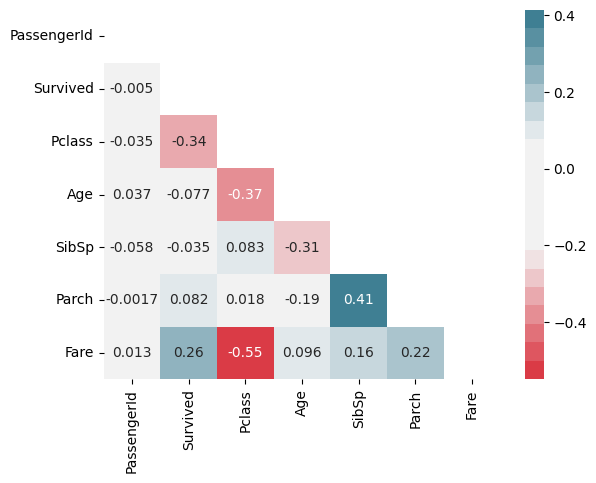

In [6]:
# or we could graph this

import seaborn as sns
import numpy as np
cmap = sns.diverging_palette(10, 220, sep=80, n=20)

mask = np.zeros_like(correlation_table, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_table,annot=True,cmap=cmap,mask=mask)

# To evaluate
these features

In [19]:
features = ['Fare','Pclass']

from sklearn.linear_model import LogisticRegression

def score(X,y):
    clf = LogisticRegression(random_state=0).fit(X, y)
    return clf.score(X, y)

print(f'''using {features} features, we score {
    score(
        df[features].values 
        ,df[target].values
    ):.2f}''')


using ['Fare', 'Pclass'] features, we score 0.68


# OR we could grab prepared inputs from a feature store

In [23]:
import feast_repo  # runs feast_repo/__init__.py

feature_view = 'passenger_stats'
feast_features = [f.name for f in feast_repo.store.get_feature_view(feature_view).features]
print(f'feast_features = {feast_features}')

feast_features = ['Fare', 'Pclass', 'encoded_title', 'female', 'male']


this view contains additional features
- Gender (one hot encoded)
- title (like Major, Countess, Col) parsed from Name 

In [24]:
df_feast = (
        feast_repo.store
        .get_historical_features(df,[feature_view+':'+f for f in feast_features])
        .to_df()
        [feast_features+[target]]
)
print('our data with feast features looks like')
df_feast.sample(5)

our data with feast features looks like


,Fare,Pclass,encoded_title,female,male,Survived
12,7.22,3,0,0,1,0
787,512.33,1,1,1,0,1
484,13.00,2,1,1,0,1
33,8.05,3,1,1,0,0
750,7.90,3,0,0,1,0


In [12]:
print(f'''previously we scored {
    score(
        df[features].values 
        ,df[target].values
    ):.2f}''')

print(f'''with feature store, we score {
     score(
        df_feast[feast_features].values 
        ,df_feast[target].values
    ):.2f}''')


previously we scored 0.68
with feature store, we score 0.79
